## Metric Calculations

In [768]:
from imports import (
    np, pd, xr, plt, os, LinearRegression,
    metrics, sys, Axes3D)

import fnmatch
from functions import regress_1d

%matplotlib inline

In [731]:
specific_model = '20191127_162007_sampleparamset_wbf_0.01_inp_1.nc'
case = specific_model[:-3]

In [732]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(model_dir) and os.path.exists(model_dir) and os.path.exists(model_dir)
print('Can access all directory paths:', access_paths)

Running on storm.uio.no, attempting to mount ns9600k/jonahks/ from NIRD
Can access all directory paths: True


In [733]:
#all_cases = os.listdir('/home/jonahks/drivemount/mnth15runs/')
all_cases = os.listdir(case_dir)

case_dir = '/home/jonahks/drivemount/mnth15runs/'

In [734]:
all_cases

['20191127_162007_sampleparamset_wbf_0.01_inp_1',
 '20191124_194151_dud',
 '20191122_161009_sampleparamset_wbf_1_inp_1',
 '20191114_183930_sampleparamset_wbf_1_inp_10',
 '20191114_183930_sampleparamset_wbf_1_inp_1',
 '20191114_183930_sampleparamset_wbf_0.01_inp_1']

In [735]:
base_case = '20191122_161009_sampleparamset_wbf_1_inp_1'
cases = ['20191127_162007_sampleparamset_wbf_0.01_inp_1', '20191122_161009_sampleparamset_wbf_1_inp_1']

In [769]:
class SLF_Metric(object):
    
    def __init__(self, casedir):
        for cls in reversed(self.__class__.mro()):
            if hasattr(cls, 'init'):
                cls.init(self, casedir)

    def init(self, casedir):
        # Catch directory issues from the get-go
        if not os.path.exists(casedir):
            print('The case directory %s does not exist' % casedir)
#            sys.exit() # Is this a problem, does it need to be here?
            
        self.case_dir = casedir
        self.origin = None
        self.cases = {}

    def set_origin(self, case): # case is a string of the case name
        if case not in self.cases: # check if it is already in the dictionary
            self.add_case(case) 
        self.origin = self.cases[case] # should have a check for the object type
        
    def add_case(self, case): # Dictionary can be overwritten, should be fine
        
        self.cases[case] = SLF_case(self.case_dir, case) # Add an slf_case object to the cases dictionary
    
    def get_case(self, case):
        if case not in self.cases: # check if it is already in the dictionary
            print('Could not find %s in the SLF_Metric object' % case)
            return None
        else:
            return self.cases[case] # should have a check for the object type
    
    def get_cases(self):
        return self.cases
#        return list(self.cases.keys()) # This is a dict_keys object and should be an iterable
    
    def get_origin(self):
        return self.origin
    
    def plot_vectors(self):
        vector_plot = plt.figure(figsize=[10,10])

        origin = [self.origin.error_slope, self.origin.error_20c] # origin point (x,y)    
        metric_cases = test.get_cases()
        for i in self.cases:
            _case = self.cases[i]
            # xy is the endpoint, xytext is the origin
            label = 'WBF: %.3f INP: %.3f, %.3f SLF RMS error' % (_case.wbf_mult, _case.inp_mult, _case.rms_error)
            plt.scatter(_case.error_slope, _case.error_20c, label=label)
            plt.annotate('', xy=(_case.error_slope, _case.error_20c), xytext=(origin[0], origin[1]), 
                        arrowprops=dict(facecolor='black', shrink=0., width=0.5, lw=1.0),
                        label = label)

        plt.scatter([[0]], [[0]], color = 'black')
        plt.xlabel('Error Slope (SLF % / C)')
        plt.ylabel('0C Isotherm SLF Error')
        plt.grid()
        plt.legend()

        return vector_plot
    
    def plot_isos(self):
        isos_plot = plt.figure(figsize=[10,10])
        plt.gca().invert_yaxis()
        isos_plot.axes[0].axvline(color='grey', linestyle='--')
        test_cases = test.get_cases() # replace with self.cases
        case_names = list(self.cases.keys())
        for j, i in enumerate(self.cases):
            _case = self.cases[i]
            label = 'WBF: %.3f INP: %.3f, %.3f SLF RMS error' % (_case.wbf_mult, _case.inp_mult, _case.rms_error)
            plt.scatter(_case.error, _case.isos, label=label)
            _r = regress_1d(_case.isos, _case.error)
            plt.plot(_r.predict(_case.isos), _case.isos)
            
        plt.xlabel('SLF Error (%)')
        plt.ylabel('Isotherm (C)')
        plt.legend()
                               
        return isos_plot
    
    def plot_parameterspace(self):
        parameterspace_plot = plt.figure()       
#        origin = [test.get_origin().wbf_mult, test.get_origin().inp_mult] # origin point (x,y)

        plt.yscale('log')
        plt.xscale('log')

        metric_cases = test.get_cases()
        for i in self.cases:
            _case = self.cases[i]
            label = 'WBF: %.3f INP: %.3f, %.3f SLF RMS error' % (_case.wbf_mult, _case.inp_mult, _case.rms_error)
            plt.annotate('', xy=(_case.wbf_mult, _case.inp_mult), xytext=(self.origin.wbf_mult, self.origin.inp_mult), 
                        arrowprops=dict(facecolor='black', shrink=0., width=0.5, lw=1.0),
                        )
            plt.scatter(_wbf, _inp, label=label)

        plt.scatter([self.origin.wbf_mult], [self.origin.inp_mult], label = 'Initial Parametrization')
        plt.scatter([[0]], [[0]], color = 'black')
        #plt.xlim((1e-3,1e2));
        #plt.ylim((1e-3,1e2))
        plt.xlabel('WBF Multiplier')
        plt.ylabel('INP Multiplier')
        plt.grid()
        plt.legend()
        
        return parameterspace_plot
    
class SLF_case:
    
    def __init__(self, casedir, case):
        self.case_dir = casedir # General directory where all cases are stored
        self.case = case # The origin case name (wbf = 1, slf = 1)
        self.case_ds = pd.read_csv('%s/%s_slf_caliop_comparison.csv' % (casedir + case, case)).dropna()
        
        # Catch an annoying error
        try:
            self.case_ds = self.case_ds.set_index('Isotherm')
        except: pass
        
        _temp_parsed = self.case.split('_') # Parse string to get model parameters
        self.date, self.time, self.paramfile = _temp_parsed[:3]
        self.wbf_mult = np.float(_temp_parsed[-3]); self.inp_mult = np.float(_temp_parsed[-1])
        self.isos = np.array(self.case_ds.index).reshape(-1,1)
        self.error = self.case_ds['Arctic Error']

        # calculate the two parameters of interest, the error slope and the -20C isotherm error
        self.error_20c = np.float(self.error.loc[[-20]]) # SLF error at the -20C isotherm (metric 2)        
        self.error_slope = np.float(regress_1d(self.isos, self.error).coef_)
        self.rms_error = np.sqrt(np.nanmean(np.power(self.error,2)))
    
    # This will go somewhere else
    def calc_rms_error(self):
        _rms_accum = 0
        for i in self.isos:
            print(i)
#            error = 

In [761]:
test = SLF_Metric(case_dir)

In [762]:
test.add_case(base_case)
print(test.get_cases())
test.add_case(cases[0])
print(test.get_cases())
test2 = test.get_case(base_case)

{'20191122_161009_sampleparamset_wbf_1_inp_1': <__main__.SLF_case object at 0x7fa0092bca90>}
{'20191122_161009_sampleparamset_wbf_1_inp_1': <__main__.SLF_case object at 0x7fa0092bca90>, '20191127_162007_sampleparamset_wbf_0.01_inp_1': <__main__.SLF_case object at 0x7fa009293780>}


In [763]:
test2.rms_error

9.105144161204992

In [764]:
test.set_origin(case_names[0])
np.float(test.get_origin().error_slope)

-0.4277083447519167

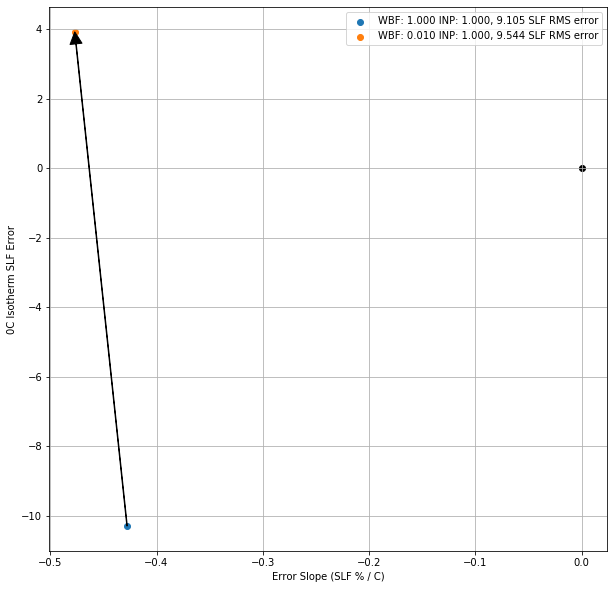

In [765]:
_temp = test.plot_vectors()

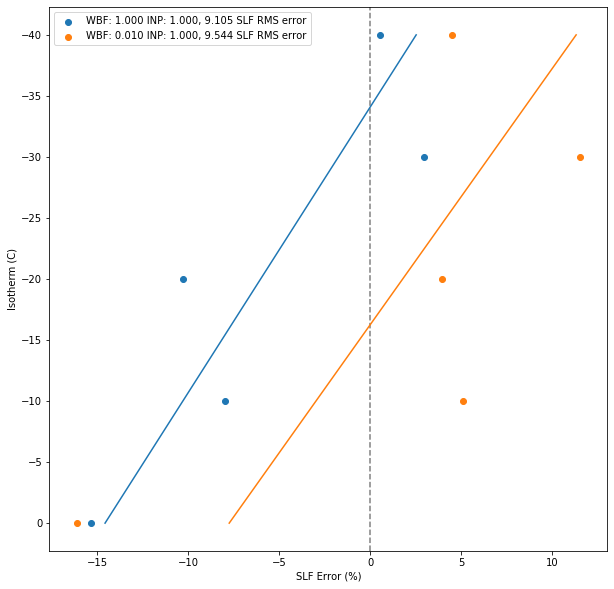

In [766]:
_temp = test.plot_isos()
#_temp.axes[0].axvline(color='grey', linestyle='--') #, x=0, ymin=0, ymax=1, **kwargs)

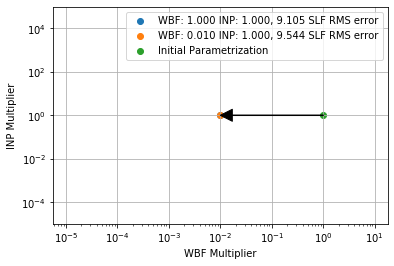

In [767]:
_temp = test.plot_parameterspace()

In [704]:
test.cases

{'20191122_161009_sampleparamset_wbf_1_inp_1': <__main__.SLF_case at 0x7fa00a6d7d30>,
 '20191127_162007_sampleparamset_wbf_0.01_inp_1': <__main__.SLF_case at 0x7fa00a6d7f98>}

1.0 1.0
0.01 1.0


<Figure size 432x288 with 0 Axes>

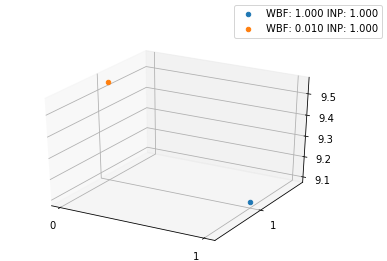

In [793]:
origin = [test.get_origin().wbf_mult, test.get_origin().inp_mult] # origin point (x,y)

plt.figure(1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#ax.yaxis.set_scale('log')
#ax.xaxis.set_scale('log')
#ax.yscale('log')
#ax.xscale('log')
#plt.yscale('log')
#plt.xscale('log')
enablelog=True

if enablelog:
    xticks = [1e-3,1e-2,1e-1,1e0,1e1]
    yticks = [1e-3,1e-2,1e-1,1e0,1e1]

    ax.set_xticks(np.log10(xticks))
    ax.set_yticks(np.log10(yticks))
#    ax.set_xlimits((0.01,10))

#    ax.set_xticklabels(xticks)
#    ax.set_yticklabels(yticks)

metric_cases = test.get_cases()
for i in metric_cases:
    _case = metric_cases[i]

    label = 'WBF: %.3f INP: %.3f' % (_case.wbf_mult, _case.inp_mult)
    print(_case.wbf_mult, _case.inp_mult)
    _wbf, _inp, _rms = _case.wbf_mult, _case.inp_mult, _case.rms_error

    # xy is the endpoint, xytext is the origin
#    plt.annotate('', xy=(_wbf, _inp), xytext=(origin[0], origin[1]), 
#                arrowprops=dict(facecolor='black', shrink=0., width=0.5, lw=1.0),
#                )
    ax.scatter(_wbf, _inp, _rms, label=label)

fig.legend()

In [779]:
ax.yaxis.s

1.0 1.0
0.01 1.0


TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable sqrt method

<Figure size 432x288 with 0 Axes>

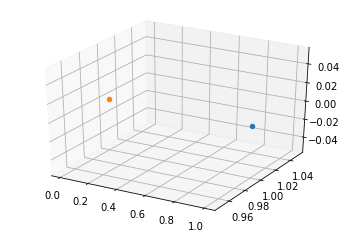

In [772]:
plt.scatter([origin[0]], [origin[1]], label = 'Initial Parametrization')
plt.scatter([[0]], [[0]], color = 'black')
#plt.xlim((1e-3,1e2));
#plt.ylim((1e-3,1e2))
plt.xlabel('WBF Multiplier')
plt.ylabel('INP Multiplier')
plt.grid()
plt.legend()
plt.show()

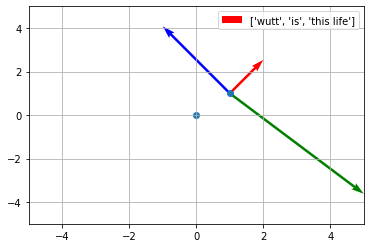

In [325]:
V = np.array([[1,1],[-2,2],[4,-3]])
origin = [test.get_origin().wbf_mult], [test.get_origin().inp_mult] # origin point (x,y)

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], label=['wutt','is','this life'], scale=10)
plt.scatter([0, 1], [0, 1])
plt.xlim((-5,5));
plt.ylim((-5,5))
plt.grid()
plt.legend()
plt.show()

## TRASSHHH

10,000 foot view of what I am trying to do

In [ ]:
test = create_base(base_case) # instantiate with the unmodified run
for case in cases:
    test.add_perturbation(case) # add the perturbations

test.performanalysis() # Plotting and calculating unit vectors, whatnot

In [198]:
os.path.exists(case_dir + base_case)
#base_case

True

In [199]:
def create_base(case_dir, origin): # pass the case name as a string, in this case base_case
    origin_ds = pd.read_csv('%s/%s_slf_caliop_comparison.csv' % (case_dir + origin, origin)).dropna() # open the .csv summary produced by jupy_test (RENAME)
    
    # Catch an annoying error
    try:
        origin_ds = origin_ds.set_index('Isotherm')
    except: pass    
    
    isos = np.array(origin_ds.index).reshape(-1,1)
    error = origin_ds['Arctic Error']
    # calculate the two parameters of interest, the error slope and the -20C isotherm error
    _r = regress_1d(isos, error)
#    _s = _r.score(isos, all_slf_clean[error])
    error_slope = _r.coef_
    
    plt.scatter(error, isos)
    
    error_20c = origin_ds.loc[[-20],['Arctic Error']] #, ["-20"]] 
    
    
    return origin_ds

,CALIOP_10N-10S,CALIOP_10S-30S,CALIOP_30N-10N,CALIOP_30S-50S,CALIOP_50N-30N,CALIOP_50S-70S,CALIOP_70N-50N,CALIOP_70S-90S,CALIOP_90N-70N,CALIOP Average,...,NorESM_10S-30S,NorESM_30N-10N,NorESM_30S-50S,NorESM_50N-30N,NorESM_50S-70S,NorESM_70N-50N,NorESM_70S-90S,NorESM_90N-70N,Arctic Error,Global Error
Isotherm,,,,,,,,,,,,,,,,,,,,,
-40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.649523,0.701112,0.734191,0.762072,0.910711,0.676523,1.686440,0.561619,0.561619,0.714611
-30.0,4.0,6.0,5.0,7.0,3.0,9.0,5.0,12.0,6.0,5.578054,...,5.272700,5.793299,6.189978,6.756526,12.026680,8.753282,14.389367,8.948410,2.948410,1.445471
-20.0,26.0,32.0,28.0,30.0,21.0,37.0,26.0,39.0,31.0,28.670216,...,11.964153,12.054469,15.180630,14.878921,28.873837,20.999265,25.780514,20.709251,-10.290749,-13.107442
-10.0,62.0,64.0,63.0,60.0,56.0,70.0,56.0,61.0,55.0,61.357769,...,30.198966,30.272848,42.999595,32.691968,50.902777,42.500702,44.331243,46.999692,-8.000308,-26.125227
0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,...,87.985580,82.179623,92.512950,81.682527,86.840288,83.434027,58.937341,84.650561,-15.349439,-13.327181


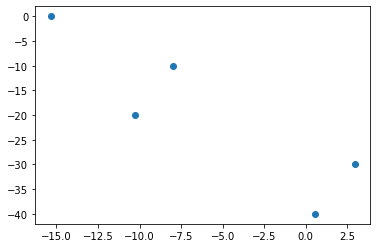

In [200]:
ds = create_base(case_dir, base_case)
ds

In [76]:
# retrieving two rows and three columns by loc method 
first = ds.loc[[-20],['Arctic Error']] #, ["-20"]] 
first

,Arctic Error
Isotherm,
-20,-10.290749


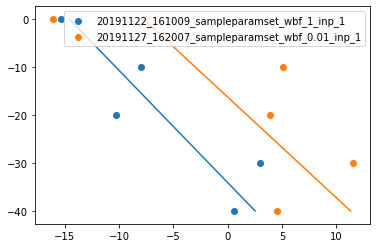

In [689]:
test_plt = plt.figure(1)
test_cases = test.get_cases()
case_names = list(test_cases.keys())
for j, i in enumerate(test_cases):
    case = test_cases[i]
    print(case)
#    plt.scatter(case.isos, case.error)
    plt.scatter(case.error, case.isos, label=str(i))
    _r = regress_1d(case.isos, case.error)
    plt.plot(_r.predict(case.isos), case.isos)
plt.legend()

#    _s = _r.score(isos, all_slf_clean[error])
#    f1_ax2.plot(_r.predict(isos), isos, color=color, label = ('$R^2 = %f$' % _s))

Isotherm
-40.0     0.561619
-30.0     2.948410
-20.0   -10.290749
-10.0    -8.000308
 0.0    -15.349439
Name: Arctic Error, dtype: float64 [[-40.]
 [-30.]
 [-20.]
 [-10.]
 [  0.]]


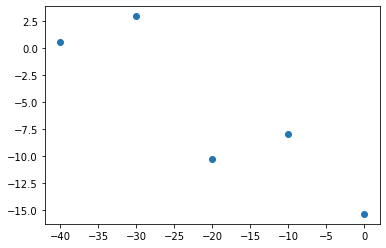

In [161]:
print(test2.error, test2.isos)
plt.scatter(test2.isos, test2.error)

[-0.4277083447519167, -10.290749029638297]
1.0 1.0
0.01 1.0


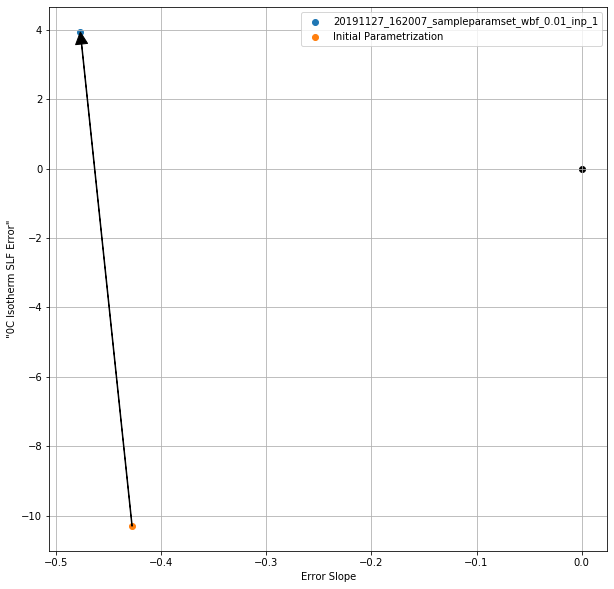

In [438]:
plt.figure(figsize=[10,10])

origin = [test.get_origin().error_slope, test.get_origin().error_20c] # origin point (x,y)
print(origin)
plt.figure(1)

metric_cases = test.get_cases()
for i in metric_cases:
    _case = metric_cases[i]
    print(_case.wbf_mult, _case.inp_mult)
    _20c_error, _slope_error = _case.error_20c, _case.error_slope
    # xy is the endpoint, xytext is the origin
    if not [_slope_error, _20c_error] == origin:
        oops = plt.scatter(_slope_error, _20c_error, label = str(i))
#        color = oops.get_color()
#        print(color)
        plt.annotate('', xy=(_slope_error, _20c_error), xytext=(origin[0], origin[1]), 
                    arrowprops=dict(facecolor='black', shrink=0., width=0.5, lw=1.0),
                    label = str(i))

plt.scatter([origin[0]], [origin[1]], label = 'Initial Parametrization')
plt.scatter([[0]], [[0]], color = 'black')
#plt.xlim((-0.5,0.5));
#plt.ylim((-15,5))
plt.xlabel('Error Slope')
plt.ylabel('0C Isotherm SLF Error')
plt.grid()
plt.legend()
plt.show()